# 2) Sensory Network
---

- Two pools of neurons now, with weights between the pools
- weights within each pool is the same


In [4]:
# IMPORTS
%matplotlib inline
import numpy as np
import math, sys, random
from pylab import *
from tqdm import tqdm_notebook as tqdm
import time
style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = [20, 8]

In [7]:
# WEIGHTS
import random
def dales(n):
    dales=[]
    for x in range(n):
        dales.append(random.randint(0, 1))
    return dales
    

def generate_weights(we, wi, n):
    weights = [[i for i in range(n)] for j in range(n)]
    
    for x in range(n):
        for y in range(n):
            if(y>x):
                weights[x][y] = we
            else:
                weights[x][y] = wi
                
    return weights
    
weights = generate_weights(we=1, wi=-1, n=10)
weights = np.asarray(weights)
np.fill_diagonal(weights, 0)

In [8]:
weights

array([[ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [-1,  0,  1,  1,  1,  1,  1,  1,  1,  1],
       [-1, -1,  0,  1,  1,  1,  1,  1,  1,  1],
       [-1, -1, -1,  0,  1,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1,  0,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  0,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1,  0,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1, -1,  0,  1,  1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  0]])

In [9]:
vrest=-65
vthresh=-50
vreset=-70
tau=20

def LIF(V, I, spike, weights):
    V += -(1/tau) * (V - vrest) + I + weights
    if V>vthresh:
        spike=True
        V=vreset
        
    return V, spike



1. Check which neurons spiked previously
2. For each new V(t), find relevant weights given previous neurons
3. If neuron 1 fired and neuron 2 is to be calc, use weight 1-2, not 2-1
4. Add summation to new V(t)

In [10]:
# generates membrane potential for each time bin
def generate_neuron_population(weights, I1, I2, n, runtime):
    # Columns: each neuron. Rows: V(t) and spikes
    track_membraneP=np.zeros((n, runtime))
    track_spikes=np.zeros((n, runtime))
    
    spike=False
    
    # time range 0-1000 
    for x in range(len(track_membraneP[0])):
        # neuron n
        for y in range(len(track_membraneP)):
            # new weight for each neuron
            sum_weight=0
            # new V(0) for each neuron
            V_start = random.uniform(vreset, vthresh)
            
            # basecase
            if (x==0):
                membrane_potential, spike = LIF(V_start, I1, spike, 0)
                
                track_membraneP[y][x] = membrane_potential
                if(spike==True):
                    track_spikes[y][x] = 1
                    spike=False
                
            else:
                # find sum of weights
                current_neuron=y
                prev_spikes=track_spikes[:, [x-1]]
                
                for spike_num in range(len(prev_spikes)):
                    if(prev_spikes[spike_num]==1):
                        sum_weight += weights[:, [current_neuron]][spike_num]
                        
                
                # use prev time bin V(t) to set new one
                if(y < len(track_membraneP)):
                    membrane_potential, spike= LIF(track_membraneP[y][x-1], I1, spike, sum_weight)
                else:
                    membrane_potential, spike= LIF(track_membraneP[y][x-1], I2, spike, sum_weight)
                

                track_membraneP[y][x] = membrane_potential
                if(spike==True):
                    track_spikes[y][x] = 1
                    spike=False
                    
    return track_membraneP, track_spikes
                

    
    
track_membraneP, track_spikes = generate_neuron_population(weights, 1, -1,  10, 1000)

In [11]:
def MSR_CV(track_spikes, track_membraneP):
    # find mean spike rate
    all_MSR=[]
    for x in track_spikes:
        all_MSR.append(np.sum(x))
    
    return np.average(all_MSR)


exampleMSR = MSR_CV(track_spikes, track_membraneP)
print("Mean MSR: ", exampleMSR)



Mean MSR:  28.6


In [12]:
def decision(track_spikes):
    # turn into just MSRs
    all_MSR=[]
    for x in track_spikes:
        all_MSR.append(np.sum(x))
        
    decision=0
    v1, v2 = 1, -1
    for idx,x in enumerate(all_MSR):
        if (idx < len(all_MSR)/2):
            decision += x*v1
        else:
            decision += x*v2
        
    return decision

decision(track_spikes)

-80.0

# All together
___

In [13]:
# neuron pop, weight w, input, runtime
def vary_W_I(n, w, I1, I2, runtime):
    # make weight matrix
    we=w
    wi=-w
    weights = generate_weights(we=1, wi=-1, n=10)
    weights = np.asarray(weights)
    np.fill_diagonal(weights, 0)

    # make neuron population
    track_membraneP, track_spikes = generate_neuron_population(weights, I1, I2, n, runtime)

#     # get MSR CV
#     exampleMSR = MSR_CV(track_spikes, track_membraneP)
#     time = runtime/1000
    
    final_decision = decision(track_spikes)
    
    
    return final_decision


In [14]:
print(vary_W_I(10, 1, 1,-1, 1000))

-81.0


# Increasing I1+I2
___

In [15]:
plot=range(30)

results=[]
for I in tqdm(plot):
    results.append(vary_W_I(10, 1, I, -I, 1000))

print(results)


[0.0, -81.0, -181.0, -270.0, -343.0, -390.0, -419.0, -454.0, -666.0, -584.0, -832.0, -665.0, -832.0, -500.0, -332.0, -334.0, -500.0, -1000.0, -1002.0, -1500.0, -1997.0, -1999.0, -2497.0, -1999.0, -1998.0, -1499.0, -1000.0, -999.0, -500.0, 0.0]


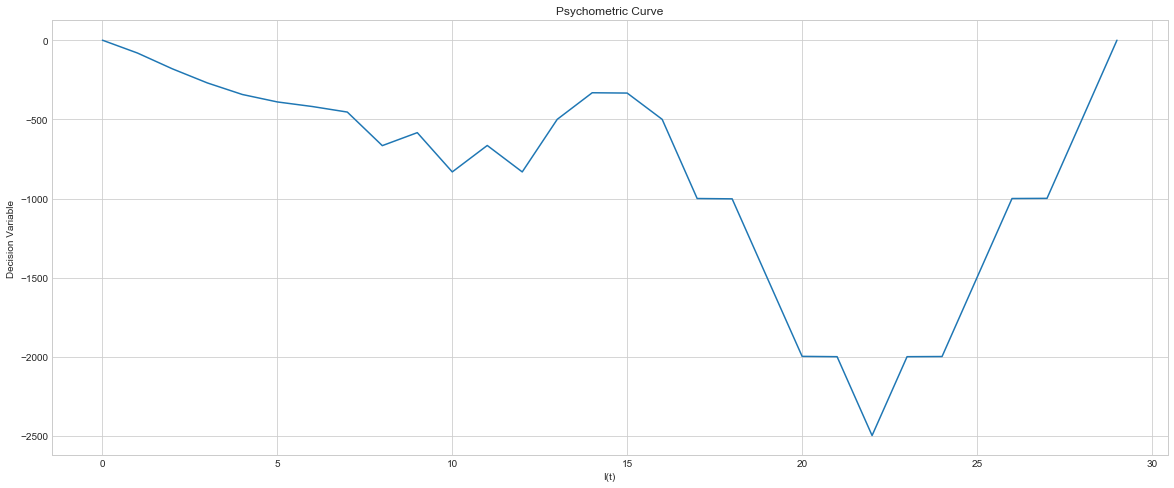

In [16]:
import numpy as np
import matplotlib.pyplot as plt
style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = [20, 8]

plt.plot(plot, results);
plt.title("Psychometric Curve")
plt.xlabel("I(t)")
plt.ylabel("Decision Variable")
plt.show()

# Increasing I1-I2
___

In [74]:
plot2=range(30)

results=[]
for I in tqdm(plot2):
    results.append(vary_W_I(10, 1, I, I, 1000))

print(results)


[0.0, -18.0, -53.0, -1.0, -2.0, 0.0, 0.0, -3.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


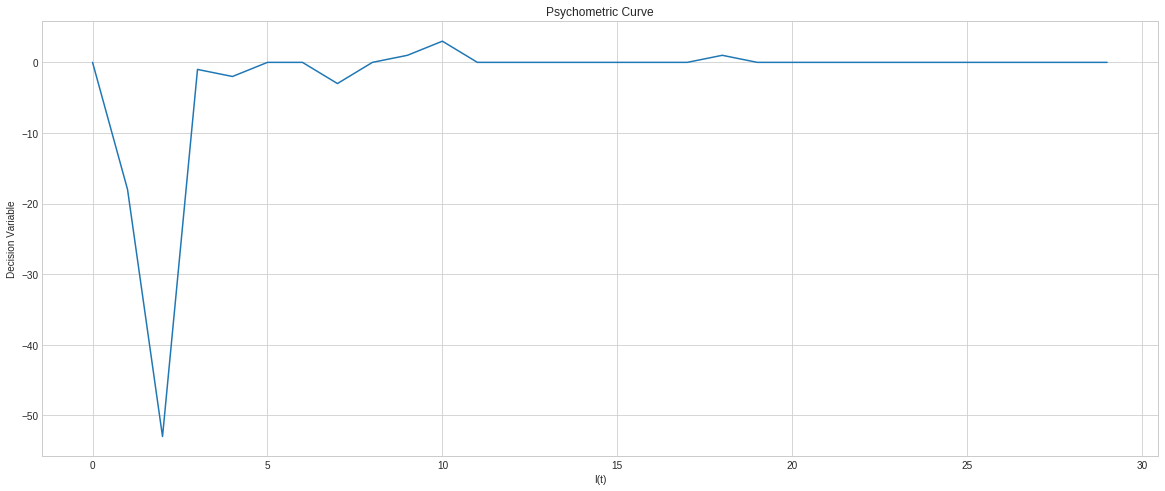

In [75]:
import numpy as np
import matplotlib.pyplot as plt
style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = [20, 8]

plt.plot(plot2, results);
plt.title("Psychometric Curve")
plt.xlabel("I(t)")
plt.ylabel("Decision Variable")
plt.show()

# Decreasing W
___

In [83]:
plot=range(30)

results=[]
for w in tqdm(plot):
    results.append(vary_W_I(10, -w, 1, 1, 1000))

print(results)


[-20.0, -1.0, -20.0, -20.0, -33.0, -19.0, -20.0, -21.0, -16.0, -17.0, -21.0, -21.0, -21.0, -19.0, -17.0, -20.0, -19.0, -21.0, -21.0, -21.0, -17.0, -2.0, -18.0, -20.0, -17.0, -21.0, -5.0, -20.0, -27.0, -27.0]


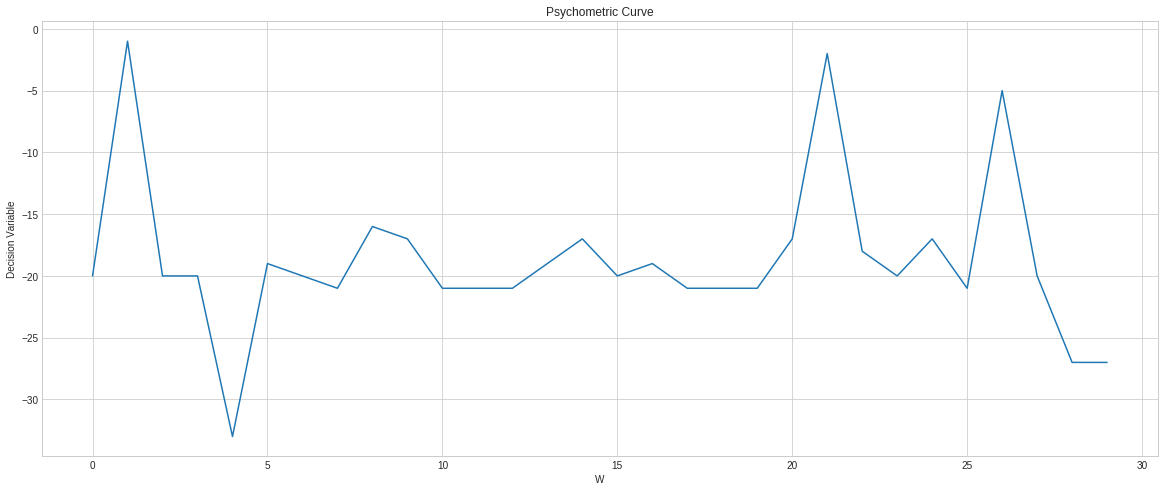

In [84]:
import numpy as np
import matplotlib.pyplot as plt
style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = [20, 8]

plt.plot(plot, results);
plt.title("Psychometric Curve")
plt.xlabel("W")
plt.ylabel("Decision Variable")
plt.show()